In [1]:
!pip install keras-unet-collection
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import IoU
from keras_unet_collection import models, utils,losses
import os
import numpy as np
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [3]:
from focal_loss import SparseCategoricalFocalLoss

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
seed=9
n_classes=3
img_dim = 400

In [8]:
def evaluateGenerator(train_img_path, train_mask_path):
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size = (img_dim,img_dim),
        class_mode = None,
        batch_size = 1,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size = (img_dim,img_dim),
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = 1,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        yield (img, mask)

In [9]:
val_img_path = '/content/gdrive/MyDrive/Limited_Dataset_Val/images/'
val_mask_path = '/content/gdrive/MyDrive/Limited_Dataset_Val/masks/'

lim_val_img_gen = evaluateGenerator(val_img_path, val_mask_path)

In [10]:
val_img_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-val/images'
val_mask_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-val/masks'

val_img_gen = evaluateGenerator(val_img_path, val_mask_path)

In [11]:
test_img_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/All images'
test_mask_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/All preprocessed masks'

test_img_gen = evaluateGenerator(test_img_path, test_mask_path)

In [16]:
x, y = test_img_gen.__next__()

Found 504 images belonging to 1 classes.
Found 504 images belonging to 1 classes.


In [17]:
x_val,y_val = val_img_gen.__next__()

Found 496 images belonging to 1 classes.
Found 496 images belonging to 1 classes.


In [18]:
x_lim_val,y_lim_val = lim_val_img_gen.__next__()

Found 192 images belonging to 1 classes.
Found 192 images belonging to 1 classes.


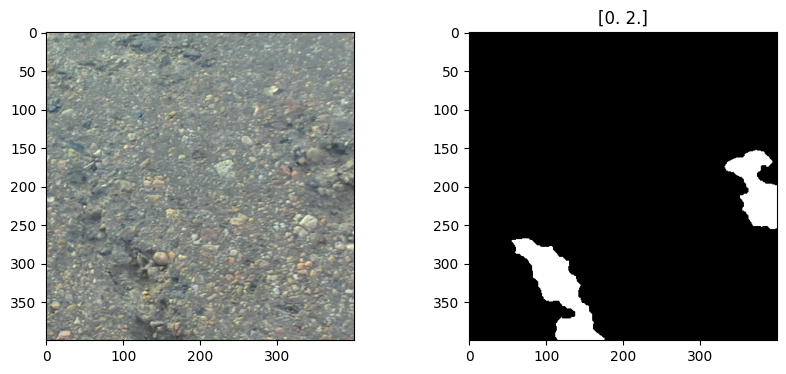

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x, y = test_img_gen.__next__()
image = x[0]
mask = y[0]
axs[0].imshow(image.astype('uint8'))
axs[1].imshow(mask,cmap='gray')
axs[1].set_title(np.unique(mask))
plt.show()

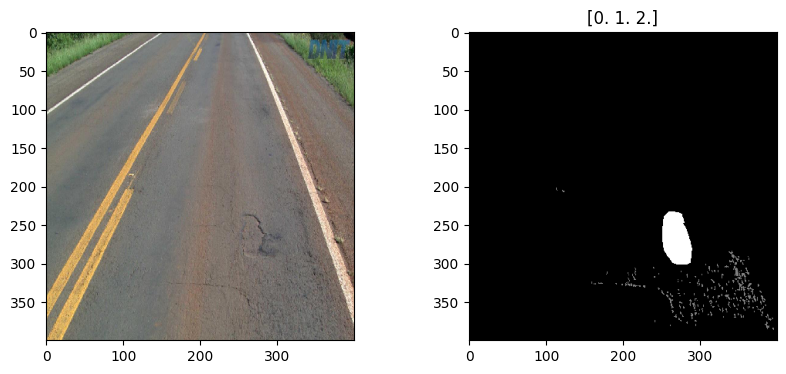

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x, y = val_img_gen.__next__()
image = x[0]
mask = y[0]
axs[0].imshow(image.astype('uint8'))
axs[1].imshow(mask,cmap='gray')
axs[1].set_title(np.unique(mask))
plt.show()

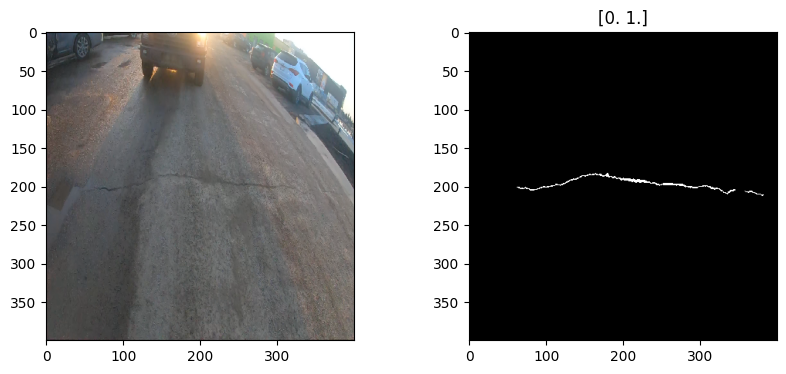

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
x, y = lim_val_img_gen.__next__()
image = x[0]
mask = y[0]
axs[0].imshow(image.astype('uint8'))
axs[1].imshow(mask,cmap='gray')
axs[1].set_title(np.unique(mask))
plt.show()

In [6]:
lim_ds = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5')

In [22]:
lim_ds.compile(metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                                     tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred=False),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[1],name='crack_iou'),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[2],name='pothole_iou')
                                     ])

In [26]:
lim_ds.metrics_names

['loss',
 'unet3plus_output_sup0_activation_sparse_categorical_accuracy',
 'unet3plus_output_sup0_activation_mean_io_u_2',
 'unet3plus_output_sup0_activation_crack_iou',
 'unet3plus_output_sup0_activation_pothole_iou',
 'unet3plus_output_sup1_activation_sparse_categorical_accuracy',
 'unet3plus_output_sup1_activation_mean_io_u_2',
 'unet3plus_output_sup1_activation_crack_iou',
 'unet3plus_output_sup1_activation_pothole_iou',
 'unet3plus_output_sup2_activation_sparse_categorical_accuracy',
 'unet3plus_output_sup2_activation_mean_io_u_2',
 'unet3plus_output_sup2_activation_crack_iou',
 'unet3plus_output_sup2_activation_pothole_iou',
 'unet3plus_output_final_activation_sparse_categorical_accuracy',
 'unet3plus_output_final_activation_mean_io_u_2',
 'unet3plus_output_final_activation_crack_iou',
 'unet3plus_output_final_activation_pothole_iou']

In [23]:
lim_ds.evaluate(test_img_gen,steps=504)

504/504 [==============================] - 78s 144ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9265 - unet3plus_output_sup0_activation_mean_io_u_2: 0.5047 - unet3plus_output_sup0_activation_crack_iou: 0.4054 - unet3plus_output_sup0_activation_pothole_iou: 0.1835 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9382 - unet3plus_output_sup1_activation_mean_io_u_2: 0.4223 - unet3plus_output_sup1_activation_crack_iou: 0.2063 - unet3plus_output_sup1_activation_pothole_iou: 0.1227 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9541 - unet3plus_output_sup2_activation_mean_io_u_2: 0.3371 - unet3plus_output_sup2_activation_crack_iou: 0.0391 - unet3plus_output_sup2_activation_pothole_iou: 0.0181 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9304 - unet3plus_output_final_activation_mean_io_u_2: 0.5086 - unet3plus_output_final_activation_crack_iou: 0.4092 - unet3plus_output_final_activation_pot

[0.0,
 0.9265299439430237,
 0.5046986937522888,
 0.40541768074035645,
 0.18347784876823425,
 0.9382253885269165,
 0.42225074768066406,
 0.2062942087650299,
 0.12271319329738617,
 0.9541349411010742,
 0.33710840344429016,
 0.039129748940467834,
 0.01808936521410942,
 0.9303992986679077,
 0.5086327791213989,
 0.40921005606651306,
 0.18751920759677887]

In [24]:
lim_ds.evaluate(val_img_gen,steps=504)

Found 496 images belonging to 1 classes.
Found 496 images belonging to 1 classes.
504/504 [==============================] - 329s 653ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9675 - unet3plus_output_sup0_activation_mean_io_u_2: 0.4926 - unet3plus_output_sup0_activation_crack_iou: 0.3024 - unet3plus_output_sup0_activation_pothole_iou: 0.2076 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9720 - unet3plus_output_sup1_activation_mean_io_u_2: 0.4186 - unet3plus_output_sup1_activation_crack_iou: 0.1516 - unet3plus_output_sup1_activation_pothole_iou: 0.1320 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9781 - unet3plus_output_sup2_activation_mean_io_u_2: 0.3386 - unet3plus_output_sup2_activation_crack_iou: 0.0270 - unet3plus_output_sup2_activation_pothole_iou: 0.0108 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9705 - unet3plus_output_final_activation_mean_io_u_2: 0.4985 - unet3plu

[0.0,
 0.9674677848815918,
 0.4925556480884552,
 0.30239543318748474,
 0.20760764181613922,
 0.9720234870910645,
 0.4185633659362793,
 0.15158873796463013,
 0.13197728991508484,
 0.9780611395835876,
 0.3386026620864868,
 0.026966314762830734,
 0.010771730914711952,
 0.9705055356025696,
 0.4984947443008423,
 0.30479469895362854,
 0.21997711062431335]

In [25]:
lim_ds.evaluate(lim_val_img_gen,steps=504)

Found 192 images belonging to 1 classes.
Found 192 images belonging to 1 classes.
504/504 [==============================] - 172s 342ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9837 - unet3plus_output_sup0_activation_mean_io_u_2: 0.6229 - unet3plus_output_sup0_activation_crack_iou: 0.4919 - unet3plus_output_sup0_activation_pothole_iou: 0.3931 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9807 - unet3plus_output_sup1_activation_mean_io_u_2: 0.4836 - unet3plus_output_sup1_activation_crack_iou: 0.2561 - unet3plus_output_sup1_activation_pothole_iou: 0.2142 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9785 - unet3plus_output_sup2_activation_mean_io_u_2: 0.3442 - unet3plus_output_sup2_activation_crack_iou: 0.0467 - unet3plus_output_sup2_activation_pothole_iou: 0.0073 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9844 - unet3plus_output_final_activation_mean_io_u_2: 0.6289 - unet3plu

[0.0,
 0.9837356209754944,
 0.622907280921936,
 0.49192294478416443,
 0.39314916729927063,
 0.9806521534919739,
 0.48362407088279724,
 0.25608640909194946,
 0.21416951715946198,
 0.9785285592079163,
 0.3441754877567291,
 0.046684689819812775,
 0.007312730886042118,
 0.9844490885734558,
 0.6288532614707947,
 0.49693000316619873,
 0.405266135931015]

In [27]:
no_aug_ds_model = load_model('/content/gdrive/MyDrive/unet models/unet3plusCTfrom40epoch.hdf5')

In [28]:
no_aug_ds_model.compile(metrics=[
                                     tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred=False),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[1],name='crack_iou'),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[2],name='pothole_iou')
                                     ])

In [31]:
no_aug_ds_model.metrics_names

['loss',
 'unet3plus_output_sup0_activation_mean_io_u_3',
 'unet3plus_output_sup0_activation_crack_iou',
 'unet3plus_output_sup0_activation_pothole_iou',
 'unet3plus_output_sup1_activation_mean_io_u_3',
 'unet3plus_output_sup1_activation_crack_iou',
 'unet3plus_output_sup1_activation_pothole_iou',
 'unet3plus_output_sup2_activation_mean_io_u_3',
 'unet3plus_output_sup2_activation_crack_iou',
 'unet3plus_output_sup2_activation_pothole_iou',
 'unet3plus_output_final_activation_mean_io_u_3',
 'unet3plus_output_final_activation_crack_iou',
 'unet3plus_output_final_activation_pothole_iou']

In [30]:
no_aug_ds_model.evaluate(test_img_gen,steps=504)

504/504 [==============================] - 79s 148ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_mean_io_u_3: 0.6077 - unet3plus_output_sup0_activation_crack_iou: 0.4291 - unet3plus_output_sup0_activation_pothole_iou: 0.4304 - unet3plus_output_sup1_activation_mean_io_u_3: 0.4736 - unet3plus_output_sup1_activation_crack_iou: 0.2186 - unet3plus_output_sup1_activation_pothole_iou: 0.2433 - unet3plus_output_sup2_activation_mean_io_u_3: 0.3395 - unet3plus_output_sup2_activation_crack_iou: 0.0365 - unet3plus_output_sup2_activation_pothole_iou: 0.0273 - unet3plus_output_final_activation_mean_io_u_3: 0.6122 - unet3plus_output_final_activation_crack_iou: 0.4336 - unet3plus_output_final_activation_pothole_iou: 0.4396


[0.0,
 0.6077443957328796,
 0.42911699414253235,
 0.43035775423049927,
 0.4735856354236603,
 0.21861223876476288,
 0.24327106773853302,
 0.3395083248615265,
 0.036536626517772675,
 0.027339870110154152,
 0.6121834516525269,
 0.43364524841308594,
 0.43959179520606995]

In [32]:
no_aug_ds_model.evaluate(val_img_gen,steps=496)

496/496 [==============================] - 63s 127ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_mean_io_u_3: 0.5349 - unet3plus_output_sup0_activation_crack_iou: 0.3227 - unet3plus_output_sup0_activation_pothole_iou: 0.3036 - unet3plus_output_sup1_activation_mean_io_u_3: 0.4375 - unet3plus_output_sup1_activation_crack_iou: 0.1572 - unet3plus_output_sup1_activation_pothole_iou: 0.1770 - unet3plus_output_sup2_activation_mean_io_u_3: 0.3383 - unet3plus_output_sup2_activation_crack_iou: 0.0240 - unet3plus_output_sup2_activation_pothole_iou: 0.0128 - unet3plus_output_final_activation_mean_io_u_3: 0.5377 - unet3plus_output_final_activation_crack_iou: 0.3279 - unet3plus_output_final_activation_pothole_iou: 0.3070


[0.0,
 0.5349028706550598,
 0.32266461849212646,
 0.303646445274353,
 0.4374955892562866,
 0.15715095400810242,
 0.17698241770267487,
 0.33832287788391113,
 0.024042626842856407,
 0.012847145088016987,
 0.5376823544502258,
 0.3278575837612152,
 0.307035893201828]

In [33]:
no_aug_ds_model.evaluate(lim_val_img_gen,steps=192)

192/192 [==============================] - 25s 127ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_mean_io_u_3: 0.5297 - unet3plus_output_sup0_activation_crack_iou: 0.5142 - unet3plus_output_sup0_activation_pothole_iou: 0.0943 - unet3plus_output_sup1_activation_mean_io_u_3: 0.4312 - unet3plus_output_sup1_activation_crack_iou: 0.2665 - unet3plus_output_sup1_activation_pothole_iou: 0.0482 - unet3plus_output_sup2_activation_mean_io_u_3: 0.3413 - unet3plus_output_sup2_activation_crack_iou: 0.0417 - unet3plus_output_sup2_activation_pothole_iou: 0.0051 - unet3plus_output_final_activation_mean_io_u_3: 0.5341 - unet3plus_output_final_activation_crack_iou: 0.5220 - unet3plus_output_final_activation_pothole_iou: 0.0995


[0.0,
 0.5296596884727478,
 0.514233410358429,
 0.0942872166633606,
 0.4311579465866089,
 0.2665308117866516,
 0.04818575829267502,
 0.3413448631763458,
 0.041687604039907455,
 0.0050742910243570805,
 0.5340612530708313,
 0.5219528079032898,
 0.09954390674829483]

In [34]:
# Qualitative analysis

In [35]:
img1 = '/content/gdrive/MyDrive/frame_0019.jpg'
img2 = '/content/gdrive/MyDrive/frame_0023.jpg'
img3 = '/content/gdrive/MyDrive/frame_0062.jpg'
img4 = '/content/gdrive/MyDrive/frame_0063.jpg'

In [36]:
images = [img1,img2,img3,img4]

In [40]:
for img in images:
  fig,axs = plt.subplots(1,3,figsize=(20,10))
  image = cv2.imread(img)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_resize = cv2.resize(image,(400,400))
  image_reshape = np.reshape(image_resize,(1,400,400,3))
  pred1 = lim_ds.predict(image_reshape)
  pred2 = no_aug_ds_model.predict(image_reshape)
  pred1_arr = np.array(pred1)
  pred2_arr = np.array(pred2)
  axs[0].imshow(image_resize)
  axs[1].imshow(pred1_arr[3][0])
  axs[2].imshow(pred2_arr[3][0])
  axs[0].set_title('Original Image')
  axs[1].set_title('Lim_DS prediction')
  axs[2].set_title('No Aug prediction')
  

Output hidden; open in https://colab.research.google.com to view.

In [8]:
from tensorflow.keras.utils import to_categorical

In [14]:
def ratingOneImage(model,img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(image,(400,400))
    img_reshaped = np.reshape(img_resized,(1,400,400,3))
    pred = model.predict(img_reshaped)
    arr = np.array(pred[3][0])
    pred_arr = np.argmax(arr,axis=2)
    pred_cat = to_categorical(pred_arr)
    pred_crack = pred_cat[:,:,1]
    pred_pothole = pred_cat[:,:,2]
    # Viz Prediction
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].imshow(img_resized)
    axs[1].imshow(pred_cat)
    # Count pixels of pothole, crack count_nonzero
    # % area of potholes =  (NOP(pothole)/NOP(total))*100
    # % area of cracks =  (NOP(craks)/NOP(total))*100
    crack_pixel = np.count_nonzero(pred_crack)
    pothole_pixel = np.count_nonzero(pred_pothole)
    
    crack_area = (crack_pixel/160000)*100
    pothole_area = (pothole_pixel/160000)*100
    #print(pothole_pixel,crack_pixel)
    
    # Rating logic
    # crack rating
    if(crack_area<=10):
        crack_rating = round(3-(crack_area/5.25),1)
    else:
        crack_rating=1
    
    # Pothole rating
    if(pothole_area<0.1):
        pothole_rating=round(3-pothole_area*10,1)
    elif(pothole_area<=1):
        pothole_rating=round(2.1-pothole_area,1)
    else:
        pothole_rating=1
    
    # Applying Weightage (weighted_rating = wr)
    wr_crack = crack_rating*1
    wr_pothole = pothole_rating*0.5
    
    # Weighted Rating Value (Avg)
    rating = round(sum([wr_crack,wr_pothole])/2,1)
    
    if(rating<=1):
        overall_condition='Poor'
    elif(rating>=1.1 and rating<=2):
        overall_condition='Fair'
    else:
        overall_condition='Good'
    
    if(pothole_area<=0.1):
        pothole_condition='Good'
    elif(pothole_area>0.1 and pothole_area<=1):
        pothole_condition='Fair'
    elif(pothole_area>1):
        pothole_condition='Poor'
    
    if(crack_area<=5):
        crack_condition='Good'
    elif(crack_area>5 and crack_area<=10):
        crack_condition='Fair'
    elif(crack_area>10):
        crack_condition='Poor'
    
    return {'Crack Area':crack_area,'Pothole Area':pothole_area,
            'Pothole Rating':wr_pothole,'Pothole Condition':pothole_condition,
            'Crack Rating':wr_crack,'Crack Condition':crack_condition,
            'Overall Rating':rating,'Overall Condition':overall_condition
           }
    
#     return pred_arr

1/1 [==============================] - 8s 8s/step


{'Crack Area': 0.11624999999999999,
 'Pothole Area': 18.619374999999998,
 'Pothole Rating': 0.5,
 'Pothole Condition': 'Poor',
 'Crack Rating': 3.0,
 'Crack Condition': 'Good',
 'Overall Rating': 1.8,
 'Overall Condition': 'Fair'}

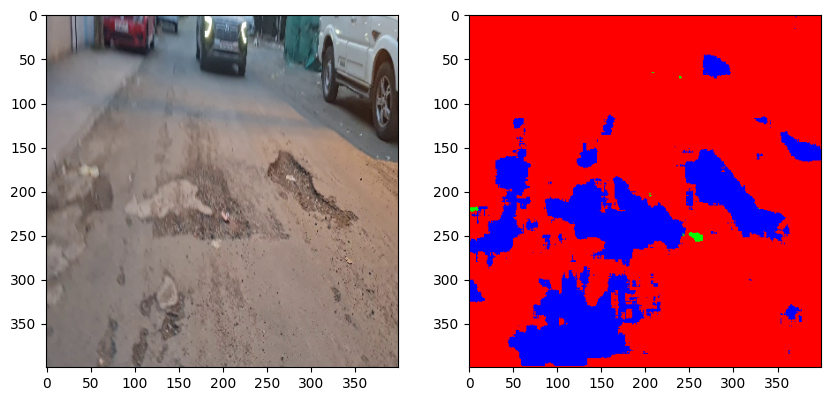

In [15]:
ratingOneImage(lim_ds,'/content/frame_0023.jpg')